In [1]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data, run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

### Generate Cubic Dataset

Generates 100 datapoints for train and 100 points for test according to the function

$$y = \frac{1}{2}x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

In [2]:
x_train, y_train, x_test = generate_data()

### Define LUNA AND NLM Hyperameters

In [14]:
######################
### COMMMON PARAMS####
######################


####  activation function ####
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

#### optimization parameters ####
optimization_params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1,
          'optimizer':'adam'}

#### model parameters #####
prior_variance = 1 # chosen in the paper. declared "reasonable". who decided this
y_noise_variance = 9 # needs to match what the dataset itself is

#### other ####
random = np.random.RandomState(0)

########################
#### LUNA SPECIFIC  ####
########################

luna_architecture = {'width': 50,
            'hidden_layers': 2,
            'input_dim': 1,
            'output_dim': 50, #number of auxiliary functions, # note, in NLM, below, we change to 1
            'activation_fn_type': activation_fn_type,
            'activation_fn_params': 'rate=1',
            'activation_fn': activation_fn}

regularization_param_luna = 1#1e-1 # in the paper they searched over 1e-3,...,1e3 and chose 1e-1 for regularization

similarity_param = 1e0 # in the paper they searched over 1e-3,...,1e3 and chose 1e0 for similarity

########################
#### NLM SPECIFIC  ####
########################

nlm_architecture = luna_architecture
nlm_architecture["output_dim"] = 1
regularization_param_nlm = 8.37 #they chose this in the paper, what a beautifully specific number



### Train NLM

In [5]:
t0 = time.time()
nlm = NLM(prior_variance,y_noise_variance, regularization_param_nlm, nlm_architecture, random)
nlm.train(x_train,y_train, optimization_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 9900 lower bound 67.42090649945163; gradient mag: 2.47523840215917629
Done Training
time: 1138.186 seconds


### Train LUNA

In [16]:
t0 = time.time()
luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, random)
luna.train(x_train, y_train, optimization_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 9900 lower bound -336008.1376783085; gradient mag: 1213.38035934395635
Done Training
time: 1132.393 seconds


### Compare Results
- notice they have identical post processing function calls

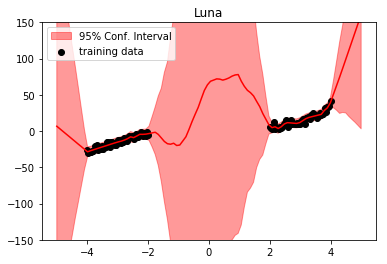

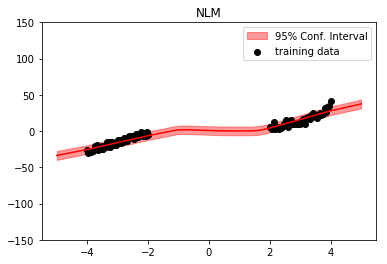

In [17]:
# fig, ax = plt.subplots(1,2, figsize = (12, 6))
i = 0
for name, model in {"Luna":luna,"NLM":nlm}.items():
    posterior_predictions, posterior_predictive_samples = model.predict(x_test)
    
    # Compute the 97.5 th percentile of the posterior predictive predictions
    pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    pp_mean = np.mean(posterior_predictive_samples, axis=0)
    
    plt.plot(x_test.flatten(), pp_mean, color='red') # visualize the mean of the posterior predictive
    plt.fill_between(x_test.flatten(), pp_upper, pp_lower, color='red', alpha=0.4, label='95% Conf. Interval') # visualize the 95% posterior predictive interval
    plt.scatter(x_train, y_train, color='black', label='training data') # visualize the training data
    plt.legend()
    plt.title(name)
    plt.ylim([-150, 150])
    plt.show()
    
    #bh.viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,name)

other notes: 
 - trained on 100 points
 